### Extraction of major peaks P-Q-R-S-T and relative time intervals

In [34]:
# Importing packages
import copy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import signal
import keras 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
import keras
import keras_tuner as kt
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import wfdb
import os
warnings.filterwarnings('ignore')

In [35]:
### Extract data from files
mitdb_list = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]
NUM_FEATURES = 21

v_dataset_data = np.empty((1,NUM_FEATURES), dtype=float)
v_dataset_categ = np.empty(1, dtype=str)

for element in mitdb_list:

    print("##########")
    print("Current record: " + str(element))

    # Load all samples
    record = wfdb.rdrecord('src/mitdb/' + str(element))
    annotation = wfdb.rdann('src/mitdb/'+str(element), 'atr')

    # Convert annotations to useful ones
    # Read symbols and substitute them
    # Classes:  'N': Normal beat
    #           'S': Supraventricular premature
    #           'V': Premature ventricular contraction
    #           'F': Fusion of ventricular and normal beat
    #           'Q': Unclassifiable
    symbol_dict = { 'N':'N',
                    'S':'S', 'A':'S', 'a':'S', 'J':'S', 'e':'S', 'j':'S', 'x':'S',
                    'V':'V', 'L':'V', 'R':'V', 'E':'V', '[':'V', '!':'V', ']':'V',
                    'F':'F', 'f':'F',
                    'Q':'Q', '/':'Q', '|':'Q'}
    raw_ann_symbol = annotation.symbol.copy()
    raw_ann_sample = annotation.sample.copy()
    #raw_ann_symbol = [symbol_dict[key] if key in symbol_dict else key for key in raw_ann_symbol]
    raw_ann_symbol = [symbol_dict[key] if key in symbol_dict else 'Z' for key in raw_ann_symbol]

    # Delete non beat annotations
    if 'Z' in raw_ann_symbol:
        i_del = [i for i, x in enumerate(raw_ann_symbol) if x == 'Z']
        raw_ann_sample = np.delete(raw_ann_sample, i_del)
        raw_ann_symbol = np.delete(raw_ann_symbol, i_del)

    
    #del raw_ann_symbol[0]
    #print(raw_ann_symbol)
    #print(raw_ann_sample)
    #print(len(raw_ann_symbol))
    #print(len(raw_ann_sample))

    # Sampling frequency
    #FREQ_SAMPLE = 360
    #FREQ_SAMPLE = 1

    # Extract ECG data array
    v_data = record.p_signal
    v_data = v_data[:,0]

    # Define time array (Fs:360Hz)
    v_time = np.arange(0, v_data.size, 1, dtype=int)

    # Zeros array for x-axis
    axis_x = np.zeros_like(v_data)

    # Calculate average of signal
    average_data = np.average(v_data)

    ### Signal filtering

    # Apply lowpass filter
    # Difference equation:
    # y(nT) = 2y(nT-T) - y(nT-2T) + x(nT) - 2x(nT-5T) + x(nT-10T)
    x = np.ones_like(v_data)*v_data
    for i in range(0,15):
        x[i] = 0
    y = np.zeros_like(v_data)
    for i in range(12, len(y)):
        y[i] = 2*y[i-1] - y[i-2] + x[i] - 2*x[i-5] + x[i-10]
    v_data_lp = np.copy(y)
    # Apply highpass filter to obtain bandpass
    # Difference equation:
    # y(nT) = -x(nT)/32 + x(nT-16T) - x(nT-17T) + x(nT-32T)/32 + y(nT-1T)
    x = np.copy(v_data_lp)
    y = np.zeros_like(v_data_lp)
    for i in range(35, len(y)):
        y[i] = -x[i]/32 + x[i-16] - x[i-17] + x[i-32]/32 + y[i-1]
    v_data_bp = np.copy(y)
    # Derivative filter
    # Difference equation:
    # y(nT) = 0.1(-x(nT-2T)) - 2x(nT-T) + 2x(nT+T) + x(nT+2T))
    x = np.copy(v_data_bp)
    y = np.zeros_like(v_data_bp)
    for i in range(2, len(y)-2):
        y[i] = 0.1*(-x[i-2] - 2*x[i-1] + 2*x[i+1] + x[i+2])
    v_data_der = np.copy(y)
    # Squaring filter
    # y(nT) = (x(nT)^2)
    v_data_sq = v_data_der*v_data_der

    # Moving average
    # Window size for moving averages
    WINDOW_TIME = 0.120 #ms
    WINDOW_NUM = int(360*WINDOW_TIME)
    v_data_avg = np.zeros_like(v_data)
    def moving_average(a, n=3):
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    tmp_avg = moving_average(v_data_sq, WINDOW_NUM)
    v_data_avg = np.pad(tmp_avg, (WINDOW_NUM-1,0), 'constant', constant_values=(tmp_avg[0],0))


    # Find R peaks
    # R peaks are extracted from the annotation array
    # R peaks are aligned to the original signal
    v_peaks_R_time = raw_ann_sample
    v_peaks_R_data_raw = np.ones_like(v_data)*-10
    for index in v_peaks_R_time:
        v_peaks_R_data_raw[index] = v_data[index]
    v_peaks_R_data = v_peaks_R_data_raw[v_peaks_R_data_raw != -10]


    ### Calculate RR times
    R_prev = 0
    RR_time = 0
    v_RR_time = np.zeros_like(v_peaks_R_time)
    for i in range(len(v_peaks_R_time)):
        if (v_peaks_R_time[i] != 0):
            RR_time = v_peaks_R_time[i] - R_prev
            R_prev = v_peaks_R_time[i]
            v_RR_time[i] = RR_time


    ### Find Q and S peaks
    v_peaks_Q_time = np.zeros_like(v_peaks_R_time)
    v_peaks_S_time = np.zeros_like(v_peaks_R_time)
    v_peaks_Q_data = np.zeros(len(v_peaks_R_time), dtype=float)
    v_peaks_S_data = np.zeros(len(v_peaks_R_time), dtype=float)
    # Find Q and S times
    for i in range(len(v_peaks_R_time)):
        # Find Q peak before current R time
        found_Q = False
        t = v_peaks_R_time[i]
        while found_Q is False:
            # Find a minumum
            if  ((v_data[t] <= v_data[t-1]) and (v_data[t] < v_data[t+1])):
                v_peaks_Q_time[i] = t
                found_Q = True
            t -= 1
        # Find S peak after current R time
        found_S = False
        t = v_peaks_R_time[i]
        while found_S is False:
            # Find a minumum
            if  ((v_data[t] <= v_data[t-1]) and (v_data[t] < v_data[t+1])):
                v_peaks_S_time[i] = t
                found_S = True
            if t==(len(v_data)-2):
                v_peaks_S_time[i] = t
                found_S = True
            else:
                t += 1
    # Find values at times of Q and S
    for i in range(len(v_peaks_R_data)):
        v_peaks_Q_data[i] = v_data[v_peaks_Q_time[i]]
        v_peaks_S_data[i] = v_data[v_peaks_S_time[i]]


    ### Define searching windows for P and T waves
    v_area_t_min = np.zeros_like(v_peaks_R_time)
    v_area_t_max = np.zeros_like(v_peaks_R_time)
    v_area_p_min = np.zeros_like(v_peaks_R_time)
    v_area_p_max = np.zeros_like(v_peaks_R_time)
    for i in range(len(v_peaks_R_time)):
        if (v_peaks_R_time[i] != 0):
            curr_time = v_peaks_R_time[i]
            # Calculate time window and convert it to index offset
            min_t = curr_time + int(0.12*v_RR_time[i])
            max_t = curr_time + int((0.57*v_RR_time[i]+0.060))
            min_p = curr_time - int(0.33*v_RR_time[i])
            max_p = curr_time - int((0.07*v_RR_time[i]+0.06))
            # Save area if window is not outside of signal
            if (max_t < v_peaks_R_time[-1]):
                for t in range(min_t, max_t):
                    v_area_t_min[i] = min_t
                    v_area_t_max[i] = max_t
            if (min_p > 0):
                for p in range(min_p, max_p):
                    v_area_p_min[i] = min_p
                    v_area_p_max[i] = max_p
    # Delete empty areas
    v_area_p_min = v_area_p_min[v_area_p_min != 0]
    v_area_p_max = v_area_p_max[v_area_p_max != 0]
    v_area_t_min = v_area_t_min[v_area_t_min != 0]
    v_area_t_max = v_area_t_max[v_area_t_max != 0]

            
    ### Apply Phasor Transform (see paper [3])
    # R_v values:
    #   0.001 for QRS
    #   0.1 for T-wave
    #   0.05 for P-wave
    # OFFSET is the shift between the raw data and the filtered data 
    OFFSET = 20
    v_phasor_qrs = np.arctan(v_data_bp/0.001)
    v_phasor_t = np.arctan(v_data_bp/0.1)
    v_phasor_p = np.arctan(v_data_bp/0.05)

    v_peaks_P_time = np.zeros_like(v_area_p_max)
    v_peaks_T_time = np.zeros_like(v_area_t_max)

    # Find max values of phasors inside searching windows
    for i in range(len(v_area_p_min)):
        v_peaks_P_time[i] = v_phasor_p[v_area_p_min[i]:v_area_p_max[i]].argmax(axis=0) + v_area_p_min[i] - OFFSET
    for i in range(len(v_area_t_min)):
        v_peaks_T_time[i] = v_phasor_t[v_area_t_min[i]:v_area_t_max[i]].argmax(axis=0) + v_area_t_min[i] - OFFSET
    v_peaks_P_data = np.zeros_like(v_peaks_P_time, dtype=float)
    v_peaks_T_data = np.zeros_like(v_peaks_T_time, dtype=float)
    for i in range(len(v_peaks_P_data)):
        v_peaks_P_data[i] = v_data[v_peaks_P_time[i]]
    for i in range(len(v_peaks_T_data)):
        v_peaks_T_data[i] = v_data[v_peaks_T_time[i]]

    ### Aggregate major points for each beat
    v_total_data = np.zeros(shape=(len(v_peaks_R_time),NUM_FEATURES))
    v_total_categ = np.empty(len(v_peaks_R_time), dtype=str)
    print("n P:" + str(len(v_peaks_P_time)) + "  n R:" + str(len(v_peaks_R_time)) + "  n T:" + str(len(v_peaks_T_time)) )
    print("n P:" + str(len(v_peaks_P_data)) + "  n R:" + str(len(v_peaks_R_data)) + "  n T:" + str(len(v_peaks_T_data)) )
    for i in range(1, len(v_peaks_R_time)-1):
        match NUM_FEATURES:
            case 21:
                # NEW SYSTEM + 3 MIDDLE POINTS
                v_total_data[i, 0] = v_peaks_R_data[i-1] - average_data
                v_total_data[i, 1] = v_peaks_S_data[i-1] - average_data
                v_total_data[i, 2] = v_peaks_S_time[i-1] - v_peaks_R_time[i-1]
                i_time = int((v_peaks_T_time[i-1] - v_peaks_S_time[i-1])/2 + v_peaks_S_time[i-1] - v_peaks_R_time[i-1])
                v_total_data[i, 3] = v_data[i_time] - average_data
                v_total_data[i, 4] = i_time
                v_total_data[i, 5] = v_peaks_T_data[i-1] - average_data
                v_total_data[i, 6] = v_peaks_T_time[i-1] - v_peaks_R_time[i-1]
                i_time = int((v_peaks_P_time[i] - v_peaks_T_time[i-1])/2 + v_peaks_T_time[i-1] - v_peaks_R_time[i-1])
                v_total_data[i, 7] = v_data[i_time] - average_data
                v_total_data[i, 8] = i_time
                v_total_data[i, 9] = v_peaks_P_data[i] - average_data
                v_total_data[i, 10] = v_peaks_P_time[i] - v_peaks_R_time[i-1]
                i_time = int((v_peaks_Q_time[i] - v_peaks_P_time[i])/2 + v_peaks_P_time[i-1] - v_peaks_R_time[i-1])
                v_total_data[i, 11] = v_data[i_time] - average_data
                v_total_data[i, 12] = i_time
                v_total_data[i, 13] = v_peaks_Q_data[i] - average_data
                v_total_data[i, 14] = v_peaks_Q_time[i] - v_peaks_R_time[i-1]
                v_total_data[i, 15] = v_peaks_R_data[i] - average_data
                v_total_data[i, 16] = v_peaks_R_time[i] - v_peaks_R_time[i-1]
                v_total_data[i, 17] = v_peaks_S_data[i] - average_data
                v_total_data[i, 18] = v_peaks_S_time[i] - v_peaks_R_time[i-1]
                v_total_data[i, 19] = v_peaks_T_data[i] - average_data
                v_total_data[i, 20] = v_peaks_T_time[i] - v_peaks_R_time[i-1]
            case 15:
                # NEW SYSTEM
                v_total_data[i, 0] = v_peaks_R_data[i-1] - average_data
                v_total_data[i, 1] = v_peaks_S_data[i-1] - average_data
                v_total_data[i, 2] = v_peaks_S_time[i-1] - v_peaks_R_time[i-1]
                v_total_data[i, 3] = v_peaks_T_data[i-1] - average_data
                v_total_data[i, 4] = v_peaks_T_time[i-1] - v_peaks_R_time[i-1]
                v_total_data[i, 5] = v_peaks_P_data[i] - average_data
                v_total_data[i, 6] = v_peaks_P_time[i] - v_peaks_R_time[i-1]
                v_total_data[i, 7] = v_peaks_Q_data[i] - average_data
                v_total_data[i, 8] = v_peaks_Q_time[i] - v_peaks_R_time[i-1]
                v_total_data[i, 9] = v_peaks_R_data[i] - average_data
                v_total_data[i, 10] = v_peaks_R_time[i] - v_peaks_R_time[i-1]
                v_total_data[i, 11] = v_peaks_S_data[i] - average_data
                v_total_data[i, 12] = v_peaks_S_time[i] - v_peaks_R_time[i-1]
                v_total_data[i, 13] = v_peaks_T_data[i] - average_data
                v_total_data[i, 14] = v_peaks_T_time[i] - v_peaks_R_time[i-1]
            case 12:
                # OLD SYSTEM
                v_total_data[i, 0] = v_peaks_T_data[i-1] - v_peaks_R_data[i-1]
                v_total_data[i, 1] = v_peaks_P_data[i] - v_peaks_T_data[i-1]
                v_total_data[i, 2] = v_peaks_Q_data[i] - v_peaks_P_data[i]
                v_total_data[i, 3] = v_peaks_R_data[i] - v_peaks_Q_data[i]
                v_total_data[i, 4] = v_peaks_S_data[i] - v_peaks_R_data[i]
                v_total_data[i, 5] = v_peaks_T_data[i] - v_peaks_S_data[i]
                v_total_data[i, 6] = v_RR_time[i]
                v_total_data[i, 7] = v_peaks_T_time[i-1] - v_peaks_R_time[i-1]
                v_total_data[i, 8] = v_peaks_P_time[i] - v_peaks_T_time[i-1]
                v_total_data[i, 9] = v_peaks_R_time[i] - v_peaks_P_time[i]
                v_total_data[i, 10] = v_peaks_S_time[i] - v_peaks_T_time[i]
                v_total_data[i, 11] = v_peaks_T_time[i] - v_peaks_R_time[i]
            case _:
                print("NUM_FEATURES: wrong value")
                v_total_data[i, 50] = 0
        
        v_total_categ[i] = raw_ann_symbol[i]
    # Delete empty data
    v_total_data = v_total_data[v_total_categ != '']
    v_total_categ = v_total_categ[v_total_categ != '']
    
    # Copy results to dataset variables
    v_dataset_data = np.append(v_dataset_data, v_total_data, axis=0)
    v_dataset_categ = np.append(v_dataset_categ, v_total_categ)

# Delete first element (empty)
v_dataset_data = v_dataset_data[1:,:]
v_dataset_categ = v_dataset_categ[1:]

print(v_dataset_categ)
print(v_dataset_data)


##########
Current record: 100
n P:2273  n R:2273  n T:2272
n P:2273  n R:2273  n T:2272
##########
Current record: 101
n P:1869  n R:1869  n T:1868
n P:1869  n R:1869  n T:1868
##########
Current record: 102
n P:2187  n R:2187  n T:2186
n P:2187  n R:2187  n T:2186
##########
Current record: 103
n P:2084  n R:2084  n T:2083
n P:2084  n R:2084  n T:2083
##########
Current record: 104
n P:2229  n R:2229  n T:2228
n P:2229  n R:2229  n T:2228
##########
Current record: 105
n P:2602  n R:2602  n T:2601
n P:2602  n R:2602  n T:2601
##########
Current record: 106
n P:2027  n R:2027  n T:2026
n P:2027  n R:2027  n T:2026
##########
Current record: 107
n P:2137  n R:2137  n T:2136
n P:2137  n R:2137  n T:2136
##########
Current record: 108
n P:1782  n R:1782  n T:1781
n P:1782  n R:1782  n T:1781
##########
Current record: 109
n P:2532  n R:2532  n T:2531
n P:2532  n R:2532  n T:2531
##########
Current record: 111
n P:2124  n R:2124  n T:2123
n P:2124  n R:2124  n T:2123
##########
Current re

In [36]:
v_dataset_data_bk = np.copy(v_dataset_data)
v_dataset_categ_bk = np.copy(v_dataset_categ)

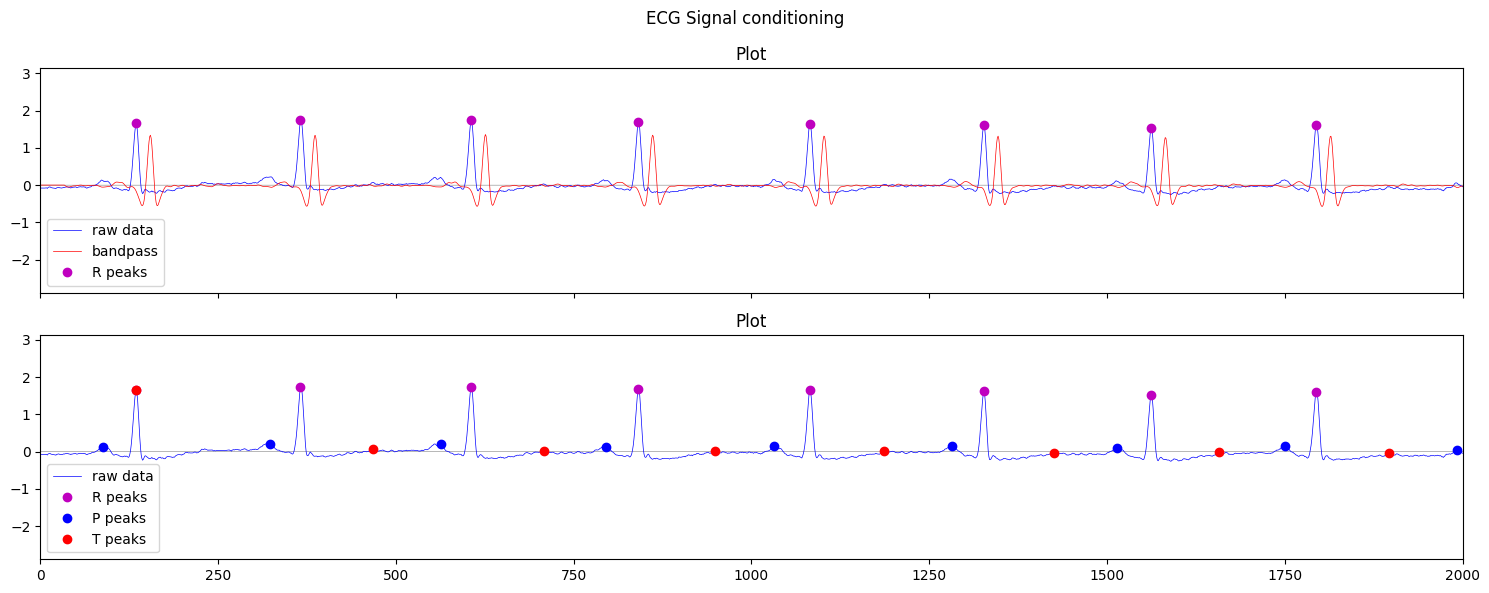

In [37]:
# Plotting window
X_MIN = 0.0
X_MAX = 2000
N_ROW = 2

n = 0
# Create plots
fig, axs = plt.subplots(N_ROW, 1, sharex=True)
fig.set_size_inches(15, 3*N_ROW)
fig.suptitle("ECG Signal conditioning")
axs[n].set_xlim(X_MIN, X_MAX)

# First plot
axs[n].title.set_text('Plot')
axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[n].plot(v_time, v_data, 'b', label="raw data", linewidth=0.5)
axs[n].plot(v_time, v_data_bp/20, 'r', label="bandpass", linewidth=0.5)
axs[n].plot(v_peaks_R_time, v_peaks_R_data, 'mo', label="R peaks", linewidth=0.5)
axs[n].legend()
n += 1

# Second plot
axs[n].title.set_text('Plot')
axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[n].plot(v_time, v_data, 'b', label="raw data", linewidth=0.5)
axs[n].plot(v_peaks_R_time, v_peaks_R_data, 'mo', label="R peaks", linewidth=0.5)
axs[n].plot(v_peaks_P_time, v_peaks_P_data, 'bo', label="P peaks", linewidth=0.5)
axs[n].plot(v_peaks_T_time, v_peaks_T_data, 'ro', label="T peaks", linewidth=0.5)
axs[n].legend()
n += 1

plt.tight_layout()
plt.show()

### NN training

In [38]:
# Prepare dataset for training
# Copy from backup data
dataset_categ = np.copy(v_dataset_categ_bk)
dataset_data = np.copy(v_dataset_data_bk)

# Convert symbols to numbers
category_dict = {   'N':0,
                    'S':1,
                    'V':2,
                    'F':3,
                    'Q':4}
dataset_categ = [category_dict[key] if key in category_dict else 'Z' for key in dataset_categ]

# Divide data into sets
DATA_SPLIT = 0.2
SEED = 1029384756
#set_train, x_valid, target_train, y_valid = train_test_split(dataset_data, dataset_categ, test_size=DATA_SPLIT, random_state=SEED)
#x_train, x_test, y_train, y_test = train_test_split(set_train, target_train, test_size=DATA_SPLIT, random_state=SEED)
x_train, x_test, y_train, y_test = train_test_split(dataset_data, dataset_categ, test_size=DATA_SPLIT, random_state=SEED)

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
#y_valid=to_categorical(y_valid)



In [39]:
# Print how many beats are in each set
tot_y_train = np.sum(y_train, axis=0)
tot_y_test = np.sum(y_test, axis=0)
#tot_y_valid = np.sum(y_valid, axis=0)
#tot_y_all = tot_y_train + tot_y_test + tot_y_valid
tot_y_all = tot_y_train + tot_y_test
print(tot_y_train)
print(tot_y_test)
#print(tot_y_valid)
print(tot_y_all)

[60039.  2584. 18423.  1427.  5692.]
[14945.   633.  4614.   357.  1493.]
[74984.  3217. 23037.  1784.  7185.]


In [40]:
# Train KNN network for different number of neighbors

knn_r_acc = []
for num_neighbors in range(3, 20):

    # Define KNN
    knn_model = KNeighborsRegressor(n_neighbors=num_neighbors)

    # Train KNN model
    knn_model.fit(x_train, y_train)

    # Extract trained model scores
    train_score = knn_model.score(x_train,y_train)
    test_score = knn_model.score(x_test,y_test)
    knn_r_acc.append((num_neighbors, test_score ,train_score))

# Print results
df = pd.DataFrame(knn_r_acc, columns=['K','Test Score','Train Score'])
print("Num features: " + str(NUM_FEATURES))
print(df)


Num features: 21
     K  Test Score  Train Score
0    3    0.666491     0.844553
1    4    0.676129     0.815413
2    5    0.679218     0.795164
3    6    0.680350     0.779253
4    7    0.679626     0.766453
5    8    0.676771     0.756164
6    9    0.676867     0.746620
7   10    0.674868     0.738770
8   11    0.673640     0.731812
9   12    0.671858     0.725601
10  13    0.669880     0.720217
11  14    0.667959     0.714916
12  15    0.664496     0.710375
13  16    0.662128     0.705370
14  17    0.659858     0.701349
15  18    0.658376     0.697538
16  19    0.656946     0.693732
